In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [3]:
image = cv2.imread('oranges_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print(f"Размер изображения: {image_gray.shape}")

Размер изображения: (275, 183)


In [4]:
# 1. Подбор параметров region growing
def homo_average(img, mask, point, T):
    if np.count_nonzero(mask) == 0:
        return True
    av_val = img[mask > 0].mean()
    return abs(av_val - img[point]) <= T

def homo_variance(img, mask, point, T):
    if np.count_nonzero(mask) == 0:
        return True
    region_pixels = img[mask > 0]
    variance = np.var(region_pixels)
    return abs(img[point] - np.mean(region_pixels)) <= T and variance <= 100

def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1

    for _ in range(1000):
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and np.any(mask[i - r:i + r + 1, j - r:j + r + 1]):
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        if np.count_nonzero(local_mask) == 0:
            break
        mask = cv2.bitwise_or(mask, local_mask)

    return mask * 255

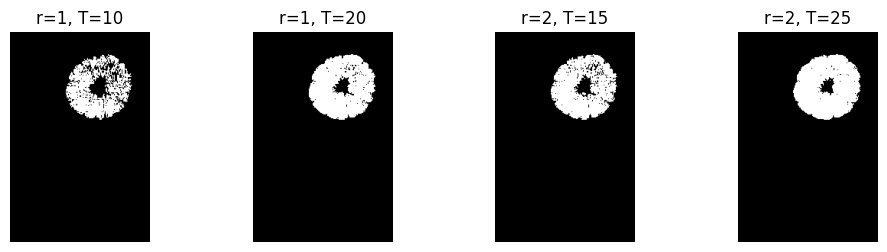

In [5]:
seed_point = (100, 100)
parameters = [(1, 10), (1, 20), (2, 15), (2, 25)]

plt.figure(figsize=(12, 6))

for i, (r, T) in enumerate(parameters):
    mask = region_growing(image_gray, seed_point, homo_average, r, T)
    plt.subplot(2, 4, i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f'r={r}, T={T}')
    plt.axis('off')

(np.float64(-0.5), np.float64(182.5), np.float64(274.5), np.float64(-0.5))

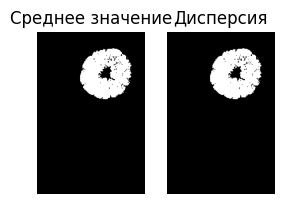

In [6]:
# 2. Сравнение критериев однородности
mask_avg = region_growing(image_gray, seed_point, homo_average, 2, 20)
mask_var = region_growing(image_gray, seed_point, homo_variance, 2, 20)

plt.subplot(2, 4, 5)
plt.imshow(mask_avg, cmap='gray')
plt.title('Среднее значение')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(mask_var, cmap='gray')
plt.title('Дисперсия')
plt.axis('off')

In [7]:
# 3. Watershed для подсчета деревьев
palm_image = cv2.imread('palm_1.JPG')
palm_gray = cv2.cvtColor(palm_image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(palm_gray, (5, 5), 0)
ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((3,3), np.uint8)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist, 0.4 * dist.max(), 255, cv2.THRESH_BINARY)  # Настроен порог

sure_fg = sure_fg.astype(np.uint8)

# Убираем шум
sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_OPEN, kernel, iterations=1)

sure_bg = cv2.dilate(sure_fg, kernel, iterations=3)
unknown = cv2.subtract(sure_bg, sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

palm_color = palm_image.copy()
markers = cv2.watershed(palm_color, markers)
palm_color[markers == -1] = [0, 0, 255]

unique_markers = np.unique(markers)
tree_count = len(unique_markers) - 2

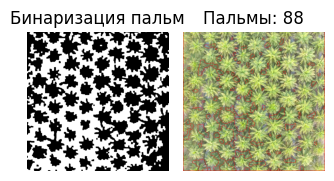

In [9]:
plt.subplot(2, 4, 7)
plt.imshow(thresh, cmap='gray')
plt.title('Бинаризация пальм')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(cv2.cvtColor(palm_color, cv2.COLOR_BGR2RGB))
plt.title(f'Пальмы: {tree_count}')
plt.axis('off')

plt.tight_layout()
plt.show()

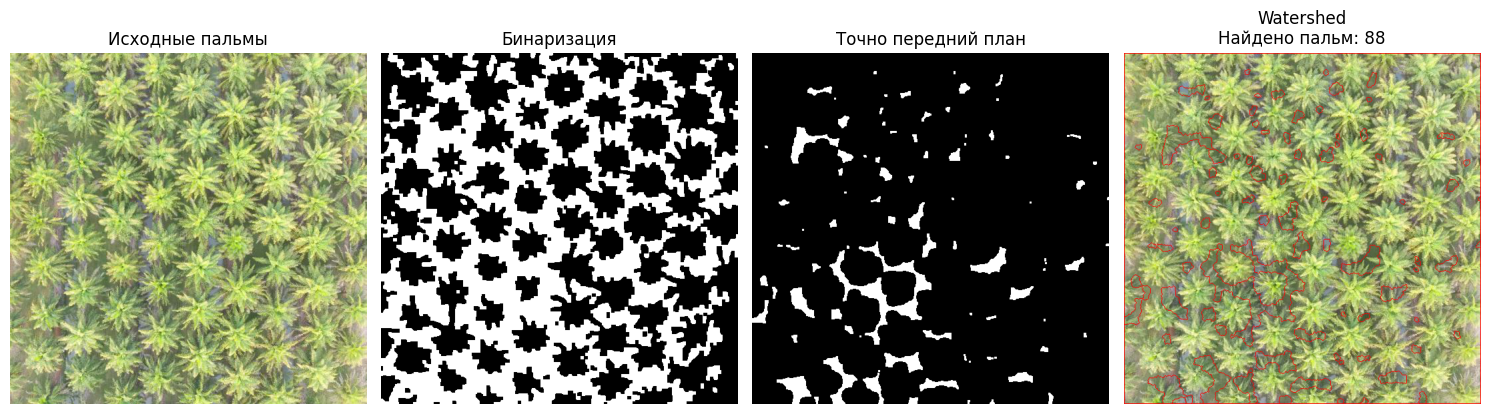

Найдено пальм: 88


In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(palm_image, cv2.COLOR_BGR2RGB))
plt.title('Исходные пальмы')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Бинаризация')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(sure_fg, cmap='gray')
plt.title('Точно передний план')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(palm_color, cv2.COLOR_BGR2RGB))
plt.title(f'Watershed\nНайдено пальм: {tree_count}')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Найдено пальм: {tree_count}")